# Correlations between Cross-sectional and pregnant women with serological data

This notebook aims to quantify the correlation between the prevalences in data from cross-sectional and the seropositivity of pregnant women  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from spatial_tools import visualise, clustering
from genomic_tools import stats
import scipy.stats as sci_stats
from genomic_tools import utils
import scipy.optimize as optimization
from stat_tools.errors import chi_square, bootstrap_resample
from stat_tools.stats import pearson_cc_boostrap
from stat_tools import tables
from pregmal_pytools import notebook_pytools, temporal_utils, spatial_utils
from time import time

In [2]:
def linfit_pcc(cross210, mipmon, mipmon_areas, cross_areas, cross_test_type, mip_test_type, cross_bins, \
                           time_width, time_shift, print_sizes = True, \
                           cross_mask = None, mip_mask = None, title = '', \
                           verbose = True, rounding = 3, get_chi2 = False):
    """
    This method outputs the linear fit parameters and the Pearson CC.
    """
    all_cross = np.array([])
    all_mip = np.array([])
    all_cross_err = np.array([])
    all_mip_err = np.array([])
    all_cross_r = []
    all_mip_r = []
    for i in range(len(mipmon_areas)):
        cross_dates, cross_mean, cross_err, cross_means = notebook_pytools.get_cross_prev_bins(cross210, cross_areas[i], \
                                                                                               cross_test_type, cross_bins, \
                                                                 print_sizes = print_sizes, cross_mask = cross_mask, \
                                                                 verbose = verbose, ret_resamples = True)
        #MiPMon
        if mip_mask is None:
            mipmon_mask = mipmon['visit'].notnull()
        else:
            mipmon_mask = mipmon['visit'].notnull()&mip_mask
        mipmon_dates, mipmon_mean, mipmon_err, mipmon_means = notebook_pytools.get_mipmon_prev_bins(mipmon, mipmon_areas[i], \
                                                                                                    mip_test_type, cross_dates, \
                                                                     time_width, time_shift, mask = mipmon_mask, \
                                                                     print_sizes = print_sizes, \
                                                                     verbose = verbose, ret_resamples = True)
        all_cross = np.concatenate((all_cross, cross_mean))
        all_cross_err = np.concatenate((all_cross_err, cross_err))
        all_cross_r.append(cross_means)
        all_mip = np.concatenate((all_mip, mipmon_mean))
        all_mip_err = np.concatenate((all_mip_err, mipmon_err))
        all_mip_r.append(mipmon_means)
    
    all_cross_r, all_mip_r = np.array(all_cross_r), np.array(all_mip_r)
    
    #Linear fits
    mask = (all_cross**2. >= 0)&(all_mip**2. >= 0)&(all_cross_err > 0)&(all_mip_err > 0)
    try:
        p_all = np.polyfit(all_cross[mask], all_mip[mask], 1)
    except:
        p_all = np.nan, np.nan
    #Pearson CC
    pcorr_all = sci_stats.pearsonr(all_cross[mask], all_mip[mask])[0]
    #chi2
    chi2 = chi_square(all_cross[mask], all_cross_err[mask], all_mip[mask], all_mip_err[mask])
    
    #Results from resamples
    fit_vals = []
    pcorrs = []
    nrands = all_cross_r.shape[-1]
    for i in range(nrands):
        mask = all_cross_r[:,:,i]**2. >= 0
        try:
            p_all_r = np.polyfit(all_cross_r[:,:,i][mask], all_mip_r[:,:,i][mask], 1)
        except:
            p_all_r = np.nan, np.nan
        fit_vals.append(p_all_r)
        pcorrs.append(sci_stats.pearsonr(all_cross_r[:,:,i][mask], all_mip_r[:,:,i][mask])[0])
    fit_vals, pcorrs = np.array(fit_vals), np.array(pcorrs)
    #Printing results
    if verbose:
        print("Cross vs MiPMon " + title + ':')
        print("Linear parameter fitting: origin = " + str(p_all[1]) + ", slope = " + str(p_all[0]))
        print("Pearson CC: ", pcorr_all)
        print()
        
    vals_mask = np.invert(np.isnan(fit_vals[:,0]))
    fit_err = np.std(fit_vals[vals_mask], axis = 0)
    pcorr_err = np.std(pcorrs)
    sorted_origin = np.sort(fit_vals[:,1])
    sorted_slope = np.sort(fit_vals[:,0])
    origin_conf_95 = [sorted_origin[int(nrands*.025)], sorted_origin[int(nrands*.975)]]
    origin_conf_68 = [sorted_origin[int(nrands*.16)], sorted_origin[int(nrands*.84)]]
    slope_conf_95 = [sorted_slope[int(nrands*.025)], sorted_slope[int(nrands*.975)]]
    slope_conf_68 = [sorted_slope[int(nrands*.16)], sorted_slope[int(nrands*.84)]]
    sorted_pcorrs = np.sort(pcorrs)
    conf_95 = [sorted_pcorrs[int(nrands*.025)], sorted_pcorrs[int(nrands*.975)]]
    conf_68 = [sorted_pcorrs[int(nrands*.16)], sorted_pcorrs[int(nrands*.84)]]
    fit_mean = np.mean(fit_vals[vals_mask], axis = 0)
    pcorr_mean = np.mean(pcorrs)
    #return p_all, pcorr_all
    
    p_all, fit_err = np.round(p_all, rounding), np.round(fit_err, rounding)
    origin_conf_95, origin_conf_68 = np.round(origin_conf_95,rounding), np.round(origin_conf_68,rounding)
    slope_conf_95, slope_conf_68 = np.round(slope_conf_95,rounding), np.round(slope_conf_68,rounding)
    fit_mean, pcorr_all = np.round(fit_mean, rounding), np.round(pcorr_all, rounding)
    pcorr_err, conf_95 = np.round(pcorr_err, rounding), np.round(conf_95, rounding)
    conf_68, pcorr_mean = np.round(conf_68, rounding), np.round(pcorr_mean, rounding)
    if get_chi2:
        return p_all, fit_err, fit_mean, origin_conf_95, origin_conf_68, slope_conf_95, \
                slope_conf_68, pcorr_all, pcorr_err, conf_95, conf_68, pcorr_mean, chi2
    else:
        return p_all, fit_err, fit_mean, origin_conf_95, origin_conf_68, slope_conf_95, \
                slope_conf_68, pcorr_all, pcorr_err, conf_95, conf_68, pcorr_mean




# Import data 

In [3]:
mipmon, cross, cross210, antigens = spatial_utils.import_spatial_data()

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/pregmal_pytools-1.0-py3.8.egg/pregmal_pytools/spatial_utils.py:290: Se

In [4]:
antigens

['MSP1',
 'HSP40',
 'Etramp',
 'ACS5',
 'EBA175',
 'PfTramp',
 'GEXP18',
 'PfRH2',
 'PfRH5',
 'P1',
 'P39',
 'P8',
 'PD',
 'DBL34',
 'All peptides',
 'P1+P8']

### Define parameters 

In [5]:
#Regions to compare
mipmon_areas = [['Magude-sede'], ['Ilha-Josina'], ['Manhica-Sede']]#, ['Pandjane'], ['3 de Fevereiro']]
cross_areas = [['Magude Sede'], ['Ilha Josina'], ['Manhiça']]#, ['Panjane'], ['Taninga', 'Palmeira', 'Malavele']]

cross_bins = ['2017', '2018', '2019', '2020']

In [6]:
colors = [cm.turbo((i+1)/float(len(mipmon_areas) + 1)) for i in range(len(mipmon_areas) + 1)]

### Define masks 

In [7]:
#Define mask for cross-sectional PCRs due to sampling issues
cross_pcr_mask = cross210['pospcr'].notnull()
cross_pcr_mask[(cross210['visdate'] < '2018')&(cross210['area'] == 'Manhiça')] = False
#cross_pcr_mask[(cross210['visdate'] > '2018')&(cross210['visdate'] < '2019')&(cross210['area'] == 'Magude Sede')] = False

#Define masks for MiPMon data
mipmon_pn = mipmon['visit'] == 'PN'
mipmon_pg = mipmon_pn&(mipmon['gestnum'] == 1)
mipmon_mg = mipmon_pn&(mipmon['gestnum'] > 1)
mipmon_hiv_pos = mipmon_pn&(mipmon['hiv'] == 'HIV+')
mipmon_hiv_neg = mipmon_pn&(mipmon['hiv'] == 'HIV-')
mipmon_pg_hiv_pos = mipmon_pg&mipmon_hiv_pos
mipmon_pg_hiv_neg = mipmon_pg&mipmon_hiv_neg

mipmon_selection = {
    'All ANC visits' : mipmon_pn,
    'Primigravidae' : mipmon_pg,
    'Multigravidae' : mipmon_mg,
    'HIV+' : mipmon_hiv_pos,
    'HIV-' : mipmon_hiv_neg,
    #'PG HIV+' : mipmon_pg_hiv_pos,
    'Primigravid HIV-' : mipmon_pg_hiv_neg,
}

### Results 

In [8]:
fontsize = 18

Cross vs MiPMon All ANC visits:
Linear parameter fitting: origin = 0.20305637872825777, slope = 1.060427265172749
Pearson CC:  0.8764461459135998



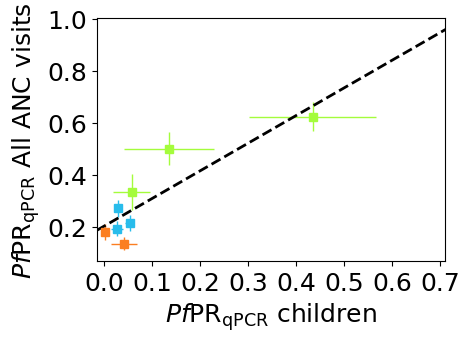

In [9]:
#Define test and time binning comparison
cross_test_type = 'pcr'
cross_mask = cross_pcr_mask
time_width = 90
time_shift = 0
ant = 'DBL34'
mip_test_type = 'FMM_' + ant
i = 'All ANC visits'
p, pcorr = notebook_pytools.scatter_linfit_pcc(cross210, mipmon, mipmon_areas, cross_areas, \
                                        cross_test_type, mip_test_type, cross_bins, \
                        time_width = time_width, time_shift = time_shift, print_sizes = False, \
                           cross_mask = cross_mask, mip_mask = mipmon_selection[i], \
                                            title = i, verbose = False, show = False, \
                                            show_identity = False, fontsize = fontsize, \
                                              legend = False)

----- MSP1 -----
Cross vs MiPMon All ANC visits:
Linear parameter fitting: origin = 0.4513533712791068, slope = 1.025104311202852
Pearson CC:  0.7978845499821263

Cross vs MiPMon Primigravidae:
Linear parameter fitting: origin = 0.4292362409131745, slope = 1.1132507633297306
Pearson CC:  0.8070697257145439

Cross vs MiPMon Multigravidae:
Linear parameter fitting: origin = 0.4617403435939528, slope = 0.9858388426866057
Pearson CC:  0.7836343614930219

Cross vs MiPMon HIV+:
Linear parameter fitting: origin = 0.4482162270449258, slope = 0.8749433592825896
Pearson CC:  0.7373908894349377

Cross vs MiPMon HIV-:
Linear parameter fitting: origin = 0.45288256796431525, slope = 1.0784898550238577
Pearson CC:  0.8022441964567703

Cross vs MiPMon Primigravid HIV-:
Linear parameter fitting: origin = 0.4385928066565472, slope = 1.224788232922644
Pearson CC:  0.7945870929441455

----- HSP40 -----
Cross vs MiPMon All ANC visits:
Linear parameter fitting: origin = 0.16745755065052997, slope = 0.826358

/home/isglobal.lan/apujol/anaconda3/envs/py38/lib/python3.8/site-packages/pregmal_pytools-1.0-py3.8.egg/pregmal_pytools/notebook_pytools.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


Cross vs MiPMon Multigravidae:
Linear parameter fitting: origin = 0.26107939635632216, slope = 1.2833235141132846
Pearson CC:  0.7985811292383067

Cross vs MiPMon HIV+:
Linear parameter fitting: origin = 0.21120324541339794, slope = 1.4104501350953622
Pearson CC:  0.7783302441156954

Cross vs MiPMon HIV-:
Linear parameter fitting: origin = 0.27502408046150006, slope = 1.1310852579577333
Pearson CC:  0.7629183056549673

Cross vs MiPMon Primigravid HIV-:
Linear parameter fitting: origin = 0.28237767829396554, slope = 0.8324471833480389
Pearson CC:  0.5631477672653427

----- EBA175 -----
Cross vs MiPMon All ANC visits:
Linear parameter fitting: origin = 0.30731098774373844, slope = 0.8892965779822335
Pearson CC:  0.8458389748900261

Cross vs MiPMon Primigravidae:
Linear parameter fitting: origin = 0.2849457091903491, slope = 0.8120891052364458
Pearson CC:  0.7584241832954427

Cross vs MiPMon Multigravidae:
Linear parameter fitting: origin = 0.3182061346400324, slope = 0.9176948849527324
P

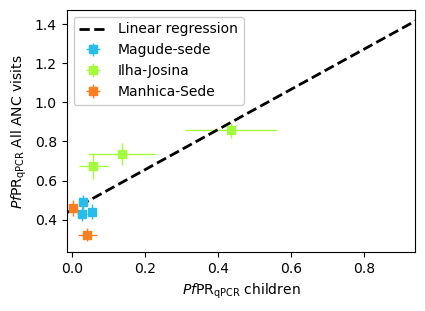

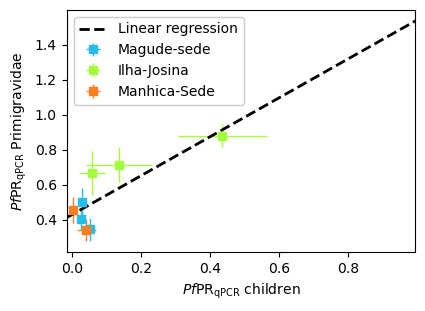

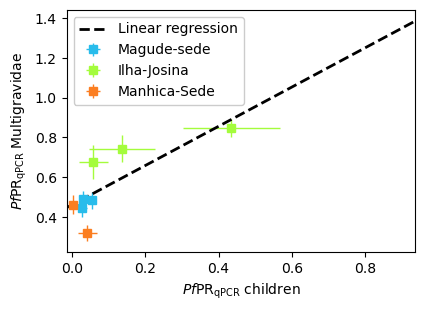

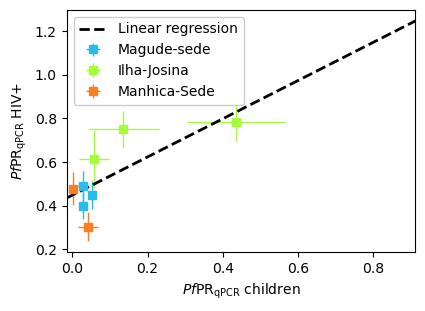

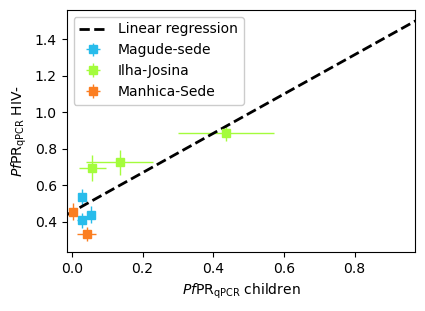

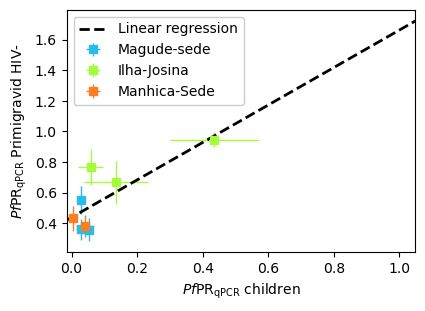

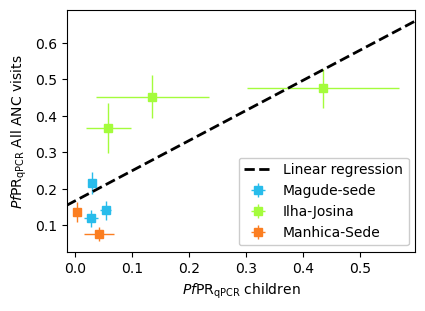

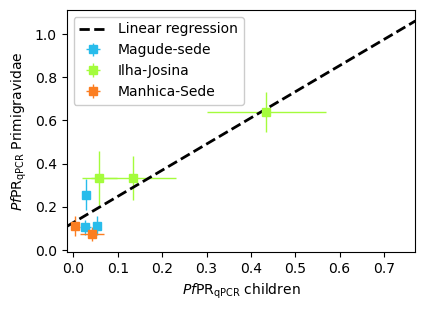

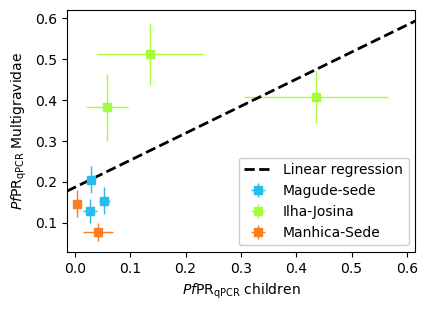

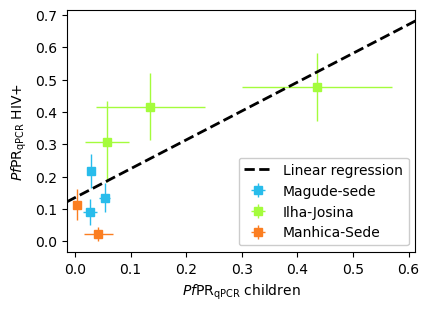

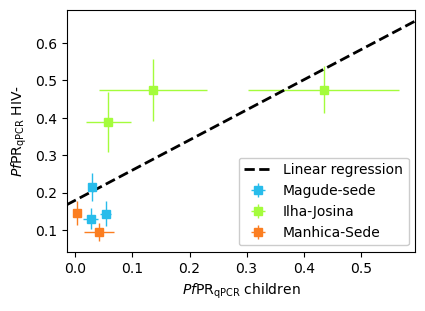

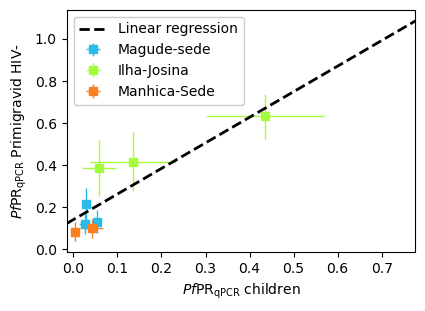

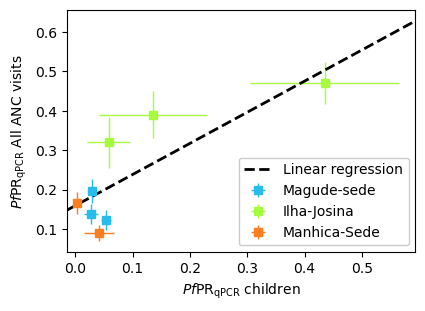

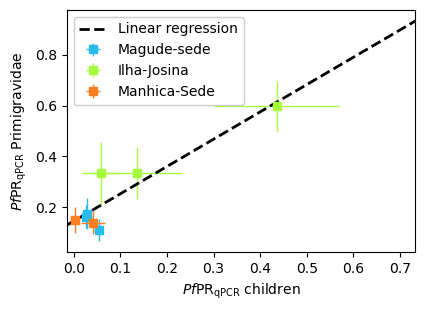

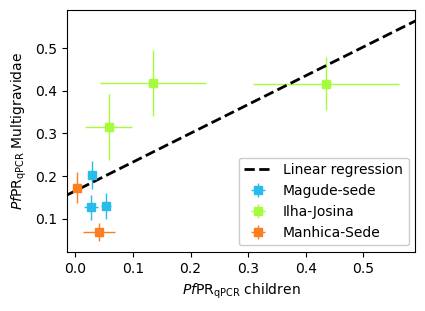

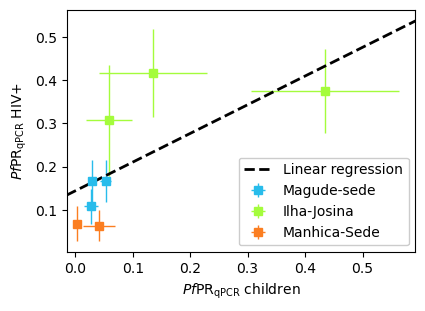

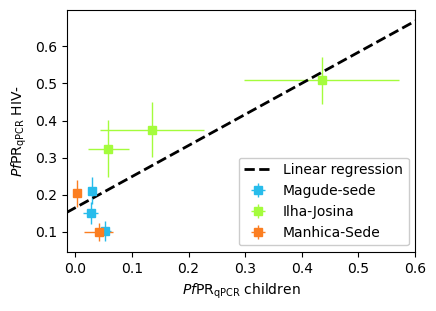

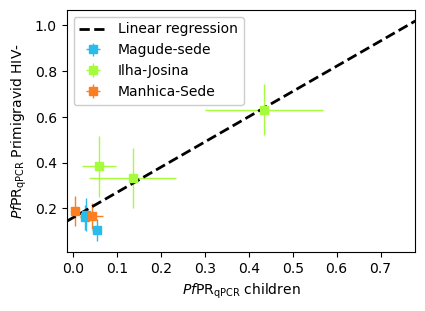

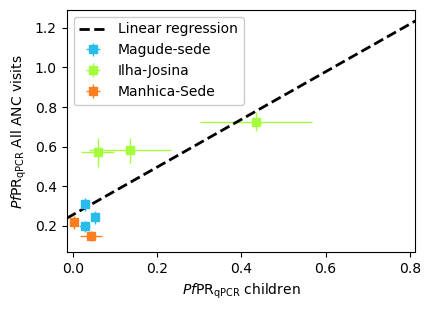

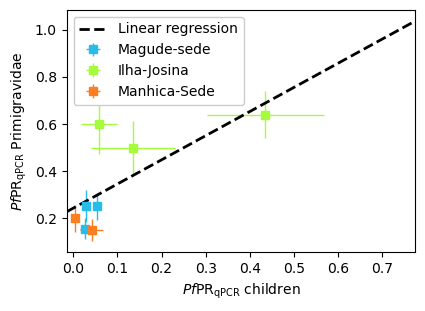

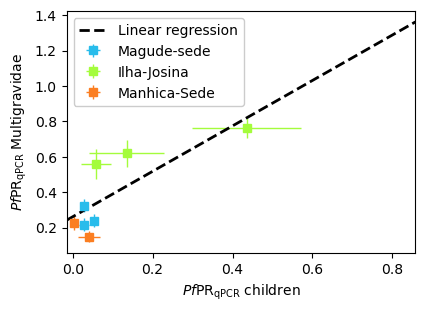

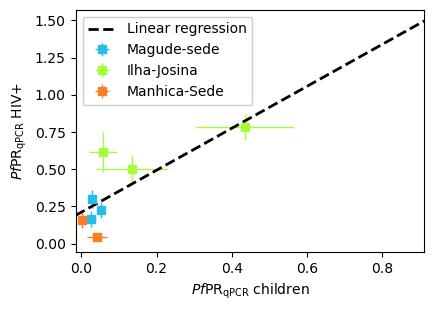

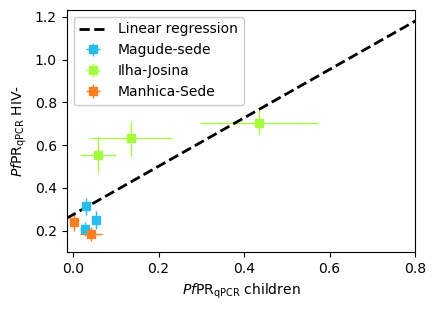

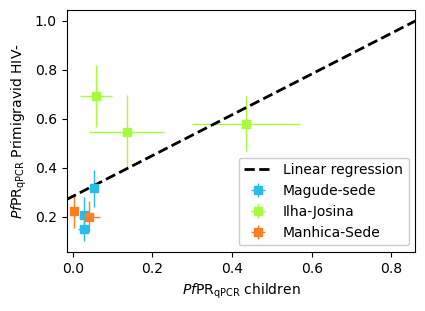

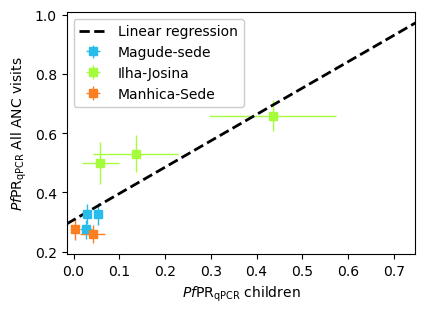

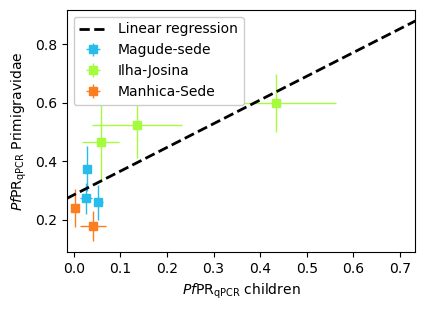

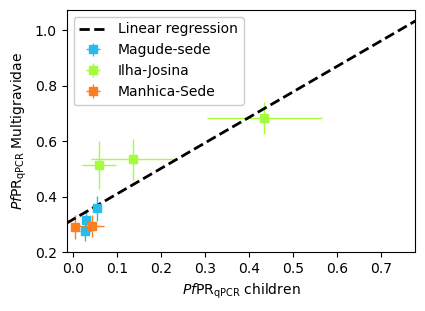

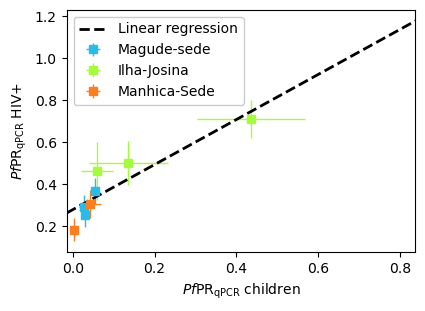

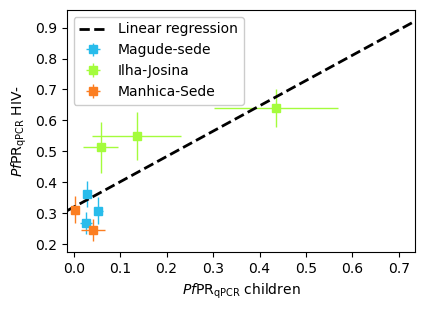

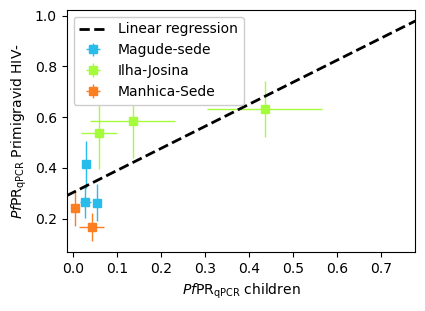

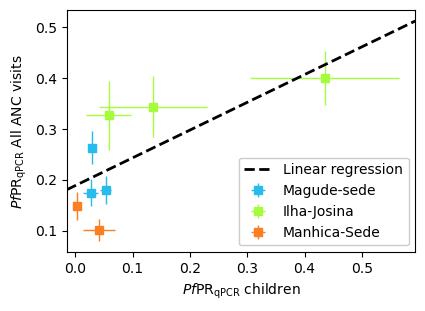

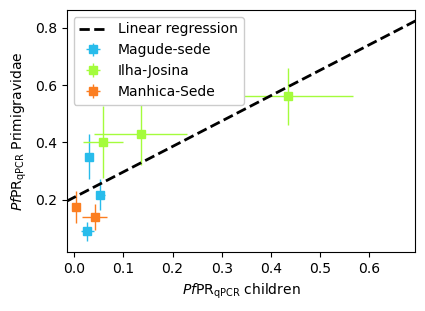

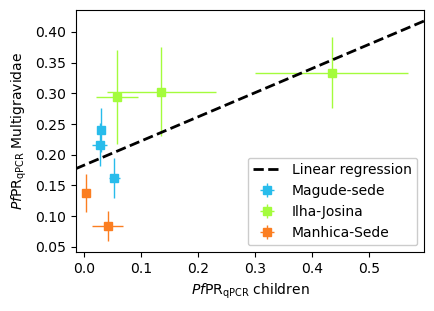

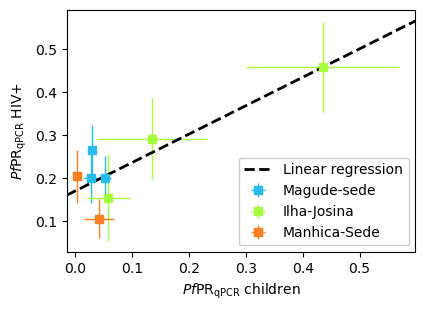

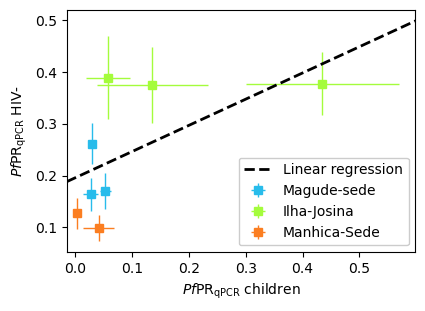

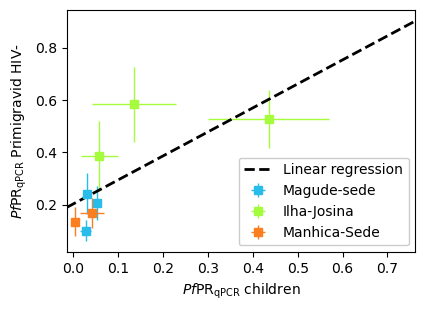

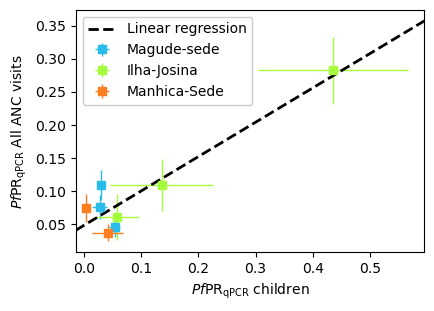

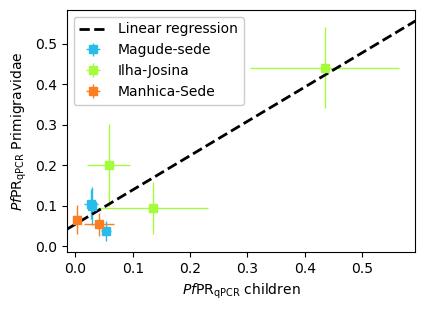

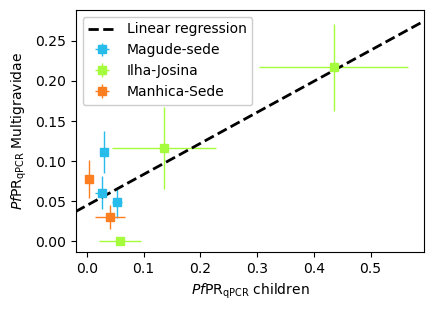

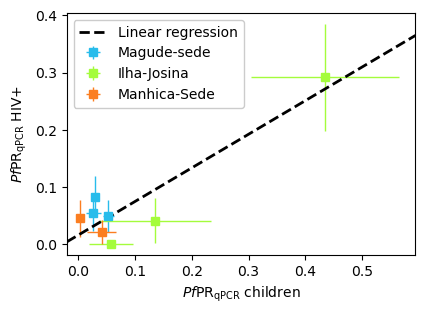

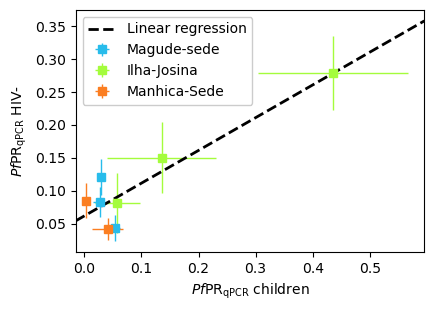

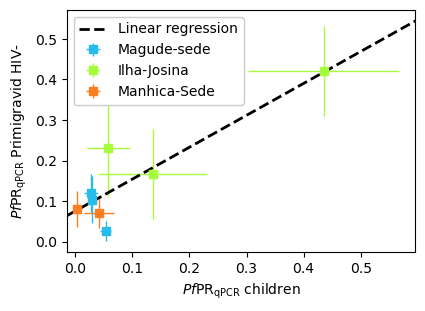

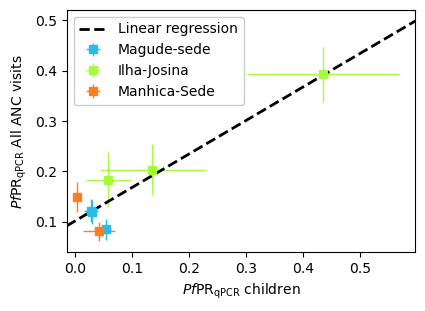

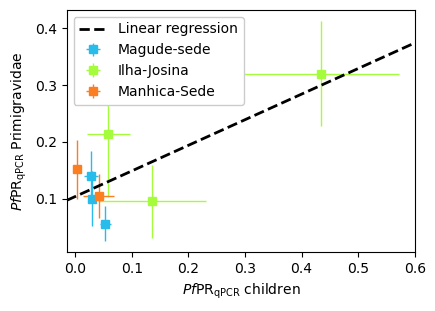

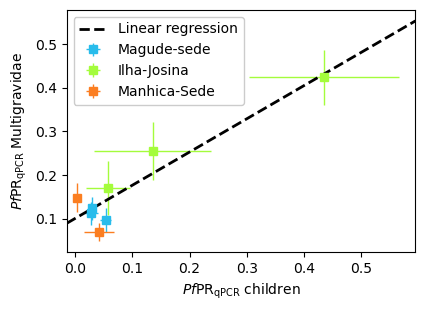

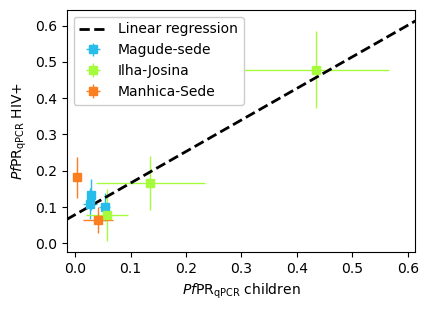

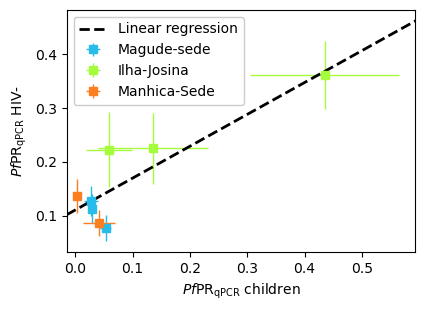

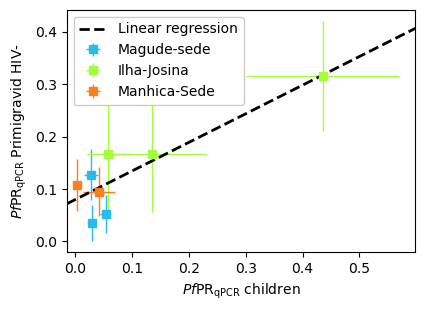

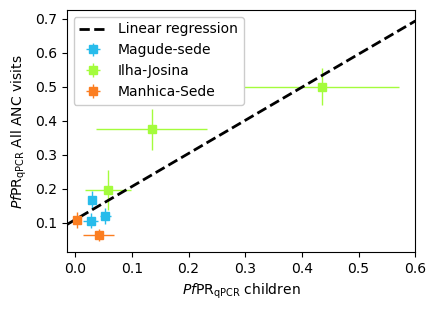

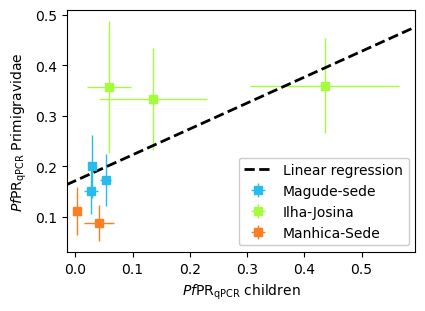

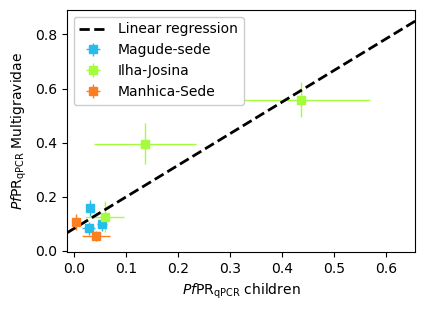

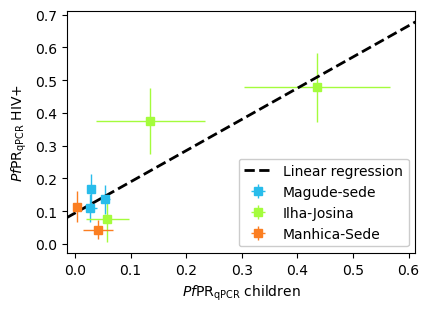

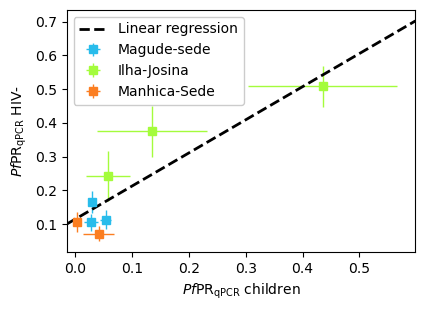

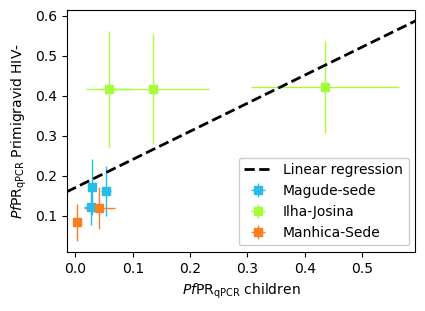

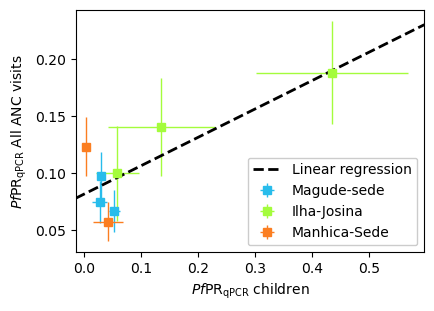

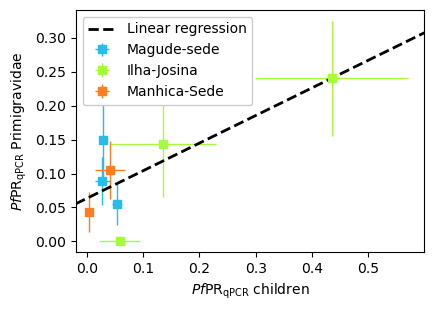

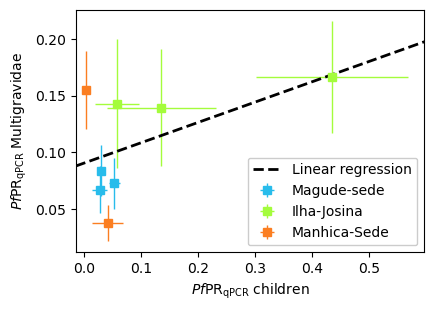

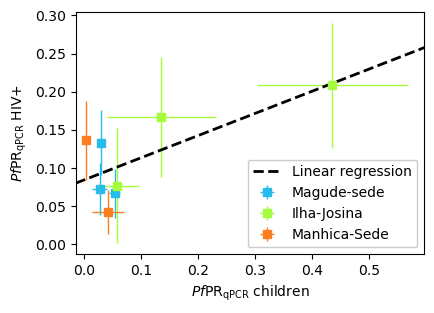

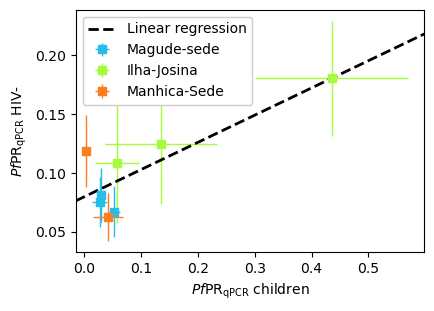

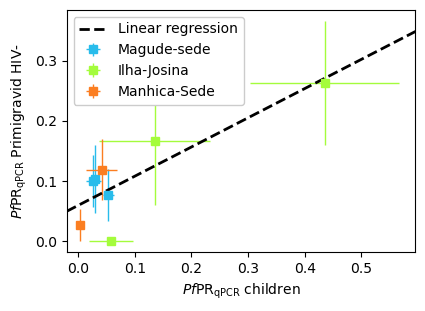

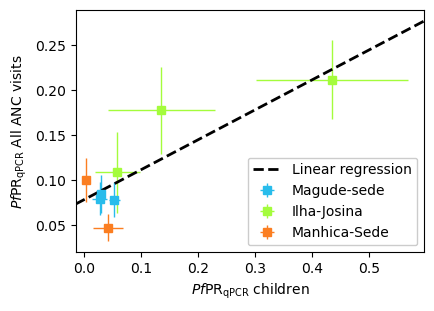

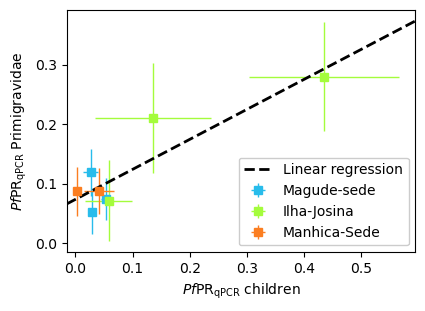

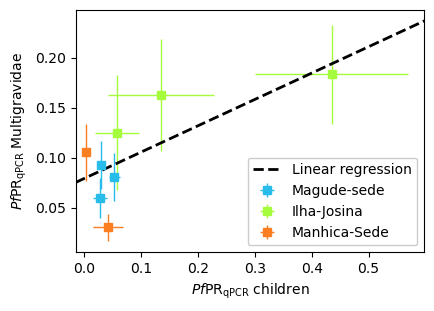

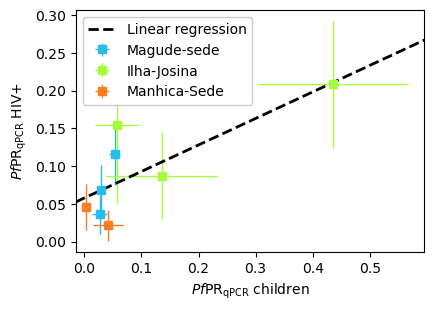

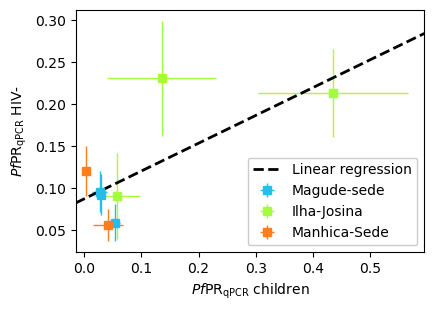

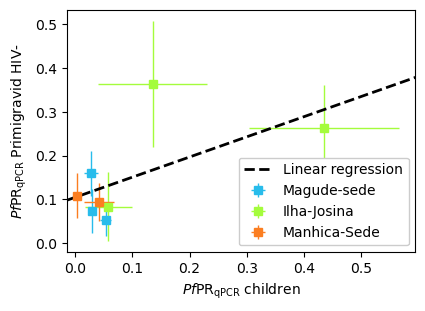

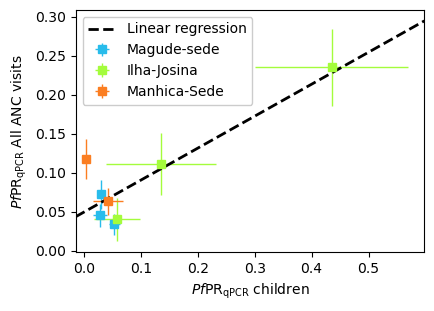

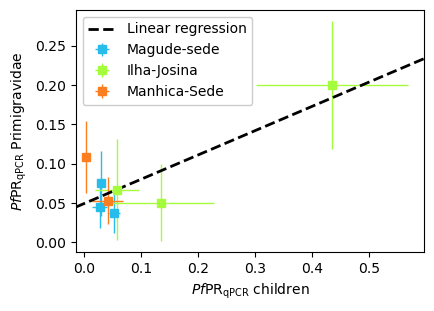

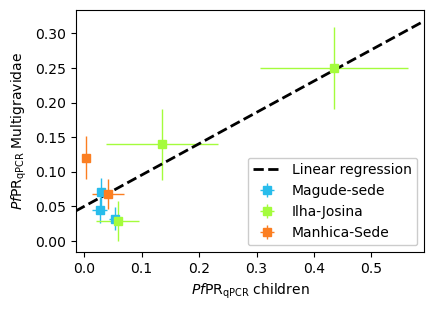

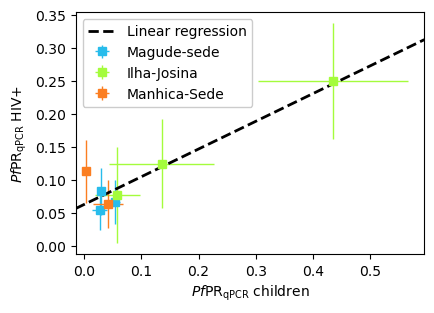

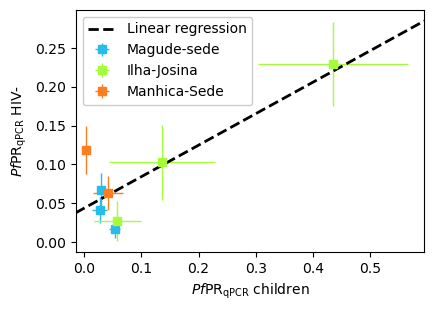

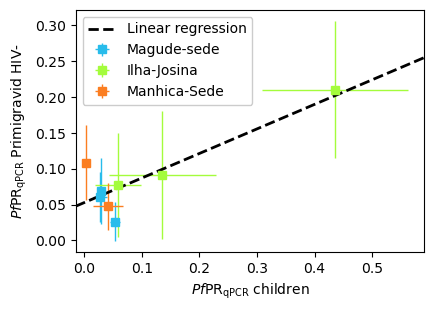

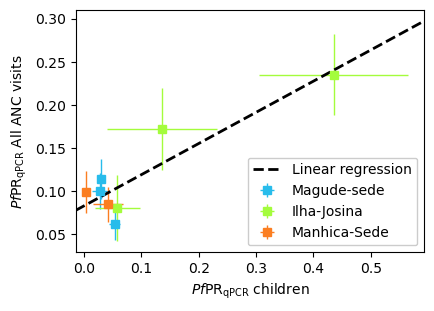

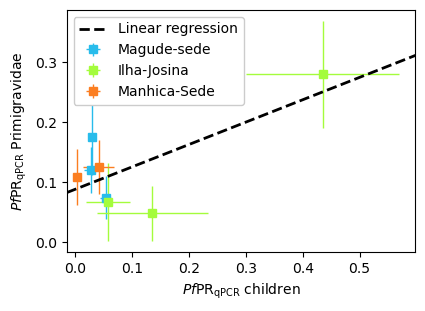

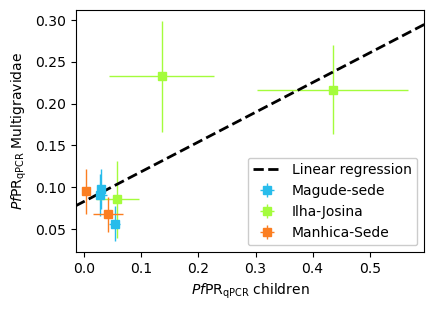

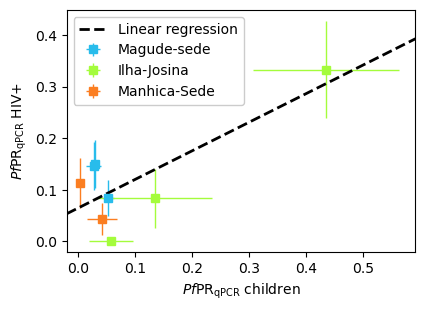

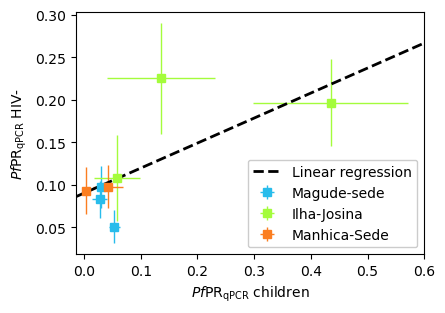

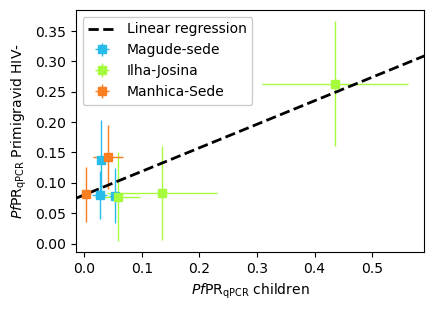

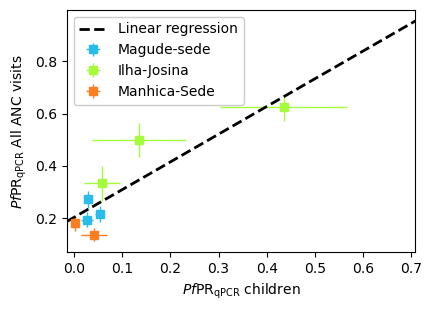

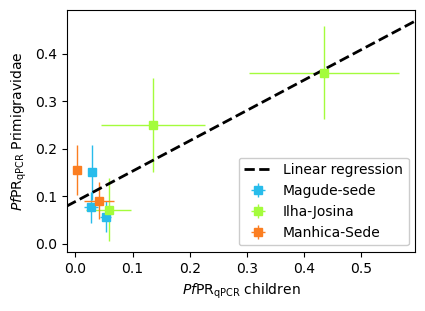

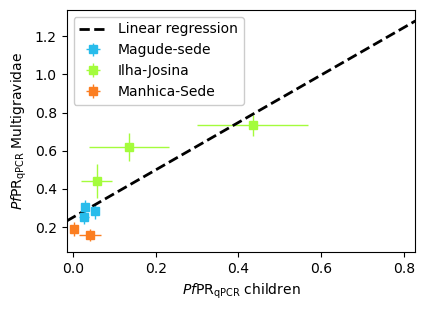

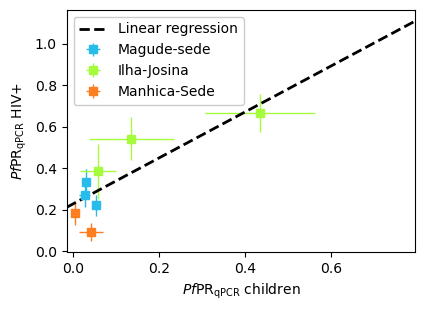

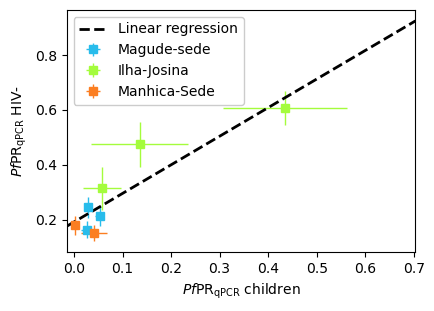

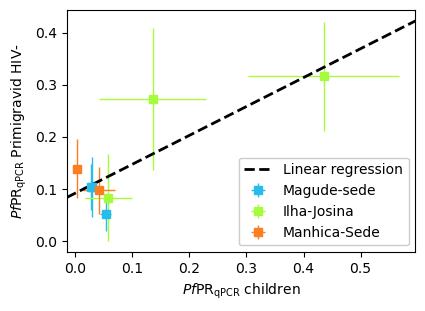

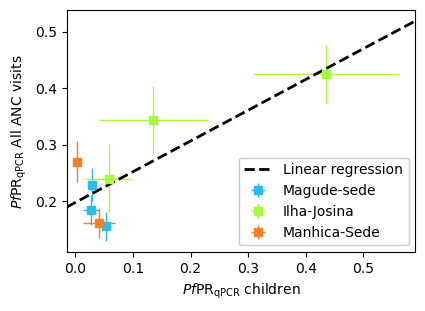

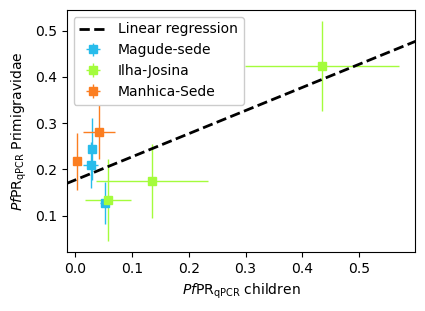

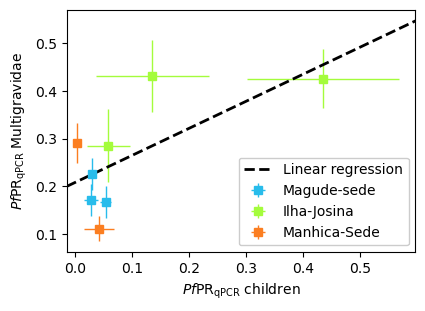

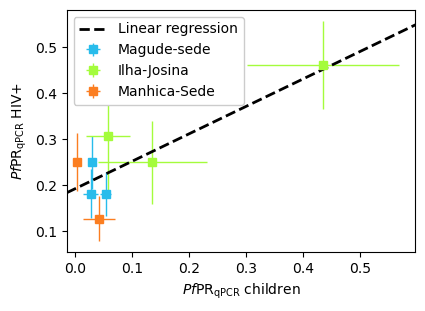

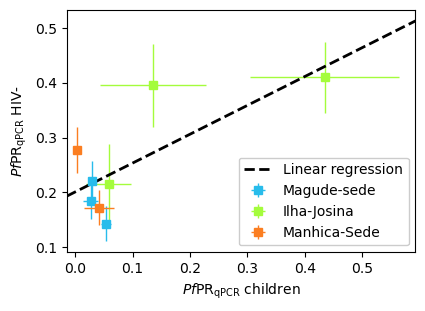

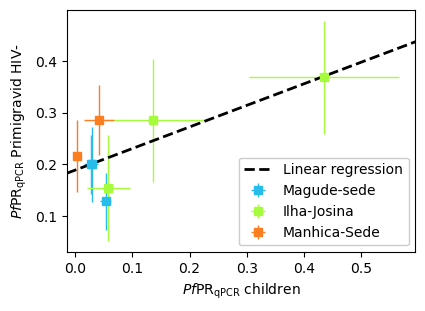

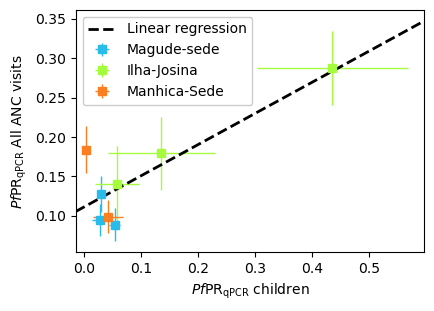

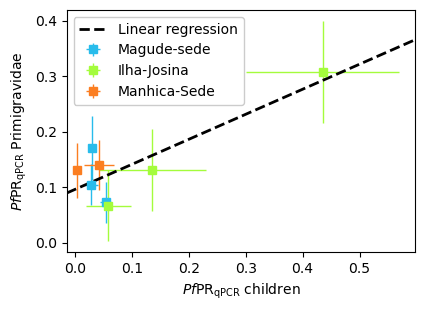

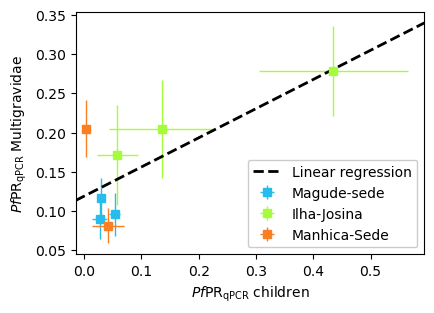

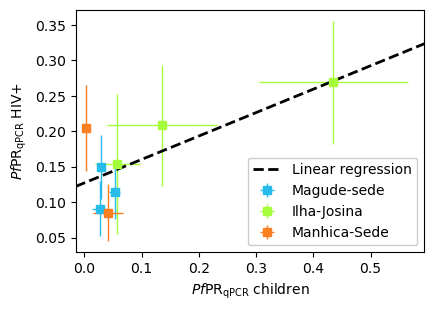

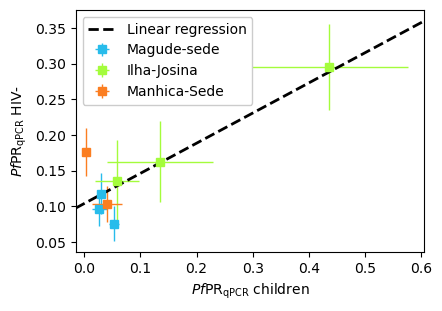

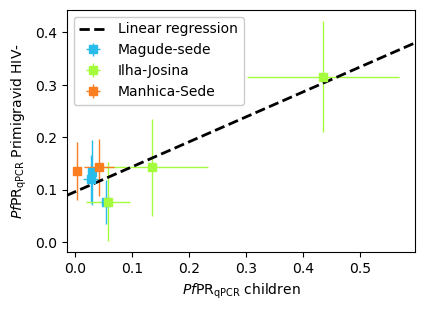

In [10]:
#Define test and time binning comparison
cross_test_type = 'pcr'
cross_mask = cross_pcr_mask
time_width = 90
time_shift = 0

start = time()
results_serology = {}
for ant in antigens:
    print("-----", ant, "-----")
    mip_test_type = 'FMM_' + ant
    
    fit_params = [{},{}]
    fit_errs = [{},{}]
    slope_95 = {}
    slope_68 = {}
    origin_95 = {}
    origin_68 = {}
    pearsonCCs = {}
    pearsonCC_errs = {}
    pearsonCC_95 = {}
    pearsonCC_68 = {}
    
    for i in mipmon_selection:
        #Plotting scatter
        p, pcorr = notebook_pytools.scatter_linfit_pcc(cross210, mipmon, mipmon_areas, cross_areas, \
                                        cross_test_type, mip_test_type, cross_bins, \
                        time_width = time_width, time_shift = time_shift, print_sizes = False, \
                           cross_mask = cross_mask, mip_mask = mipmon_selection[i], \
                                            title = i, verbose = False, show = False, \
                                                      show_identity = False)
        
        #Calculating statistics
        p_all, fit_err, fit_mean, origin_95[i], origin_68[i], slope_95[i], slope_68[i], \
        pearsonCCs[i], pearsonCC_errs[i], pearsonCC_95[i], pearsonCC_68[i], pcorr_mean = linfit_pcc(cross210, \
                                                            mipmon, mipmon_areas, cross_areas, \
                                                            cross_test_type, mip_test_type, cross_bins, \
                                                time_width = time_width, time_shift = 0, print_sizes = False, \
                                                   cross_mask = cross_mask, mip_mask = mipmon_selection[i], \
                                                            title = i, verbose = False, rounding = 2)
        fit_params[0][i], fit_params[1][i] = p_all
        fit_errs[0][i], fit_errs[1][i] = fit_err
    
    results_serology[ant] = pd.DataFrame({'Slope': fit_params[0], \
                          #'Slope error': fit_errs[0], \
                          'Slope 95CI': slope_95, \
                            #'Slope 68CI': slope_68, \
                          'Origin': fit_params[1], \
                          #'Origin error': fit_errs[1], \
                          'Origin 95CI': origin_95, \
                          #'Origin 68CI': origin_68, \
                          'PCC' : pearsonCCs, \
                          #'PCC error' : pearsonCC_errs, \
                          'PCC 95CI' : pearsonCC_95,\
                          #'PCC 68CI' : pearsonCC_68
                         })
end = time()
print('Time taken ', end-start,' seconds (', int((end-start)/60), 'minutes)')

In [11]:
all_serology_results = pd.DataFrame({})
for ant in antigens:
    for s in mipmon_selection:
        all_serology_results[ant + ' ' + s] = results_serology[ant].T[s]
    

### Visualising the results

In [12]:
fontsize = 18

In [13]:
pcr_results = pd.DataFrame({
    'PCC' : {'All prenatal' : .941, \
             'Primigravidae' : .919, \
            'Multigravidae' : .947, \
            'HIV+' : .879, \
            'HIV-' : .952, \
            'Primigravid HIV-' : .861}, 
    'PCC 95CI' : {'All prenatal' : [.698, .985], \
                  'Primigravidae' : [.527, .979], \
                 'Multigravidae' : [.636, .988], \
                 'HIV+' : [.292, .977], \
                 'HIV-' : [.698, .986], \
                 'Primigravid HIV-' : [.453, .972]}
})
rdt_results = pd.DataFrame({
    'PCC' : {'All prenatal' : .841, \
             'Primigravidae' : .672, \
            'Multigravidae' : .608, \
            'HIV+' : .960, \
            'HIV-' : .760, \
            'Primigravid HIV-' : .655}, 
    'PCC 95CI' : {'All prenatal' : [.307, .952], \
                  'Primigravidae' : [.093, .939], \
                 'Multigravidae' : [-.121, .936], \
                 'HIV+' : [.049, .976], \
                 'HIV-' : [.223, .937], \
                 'Primigravid HIV-' : [.112, .935]}
})
parasitology_results = [pcr_results, rdt_results]

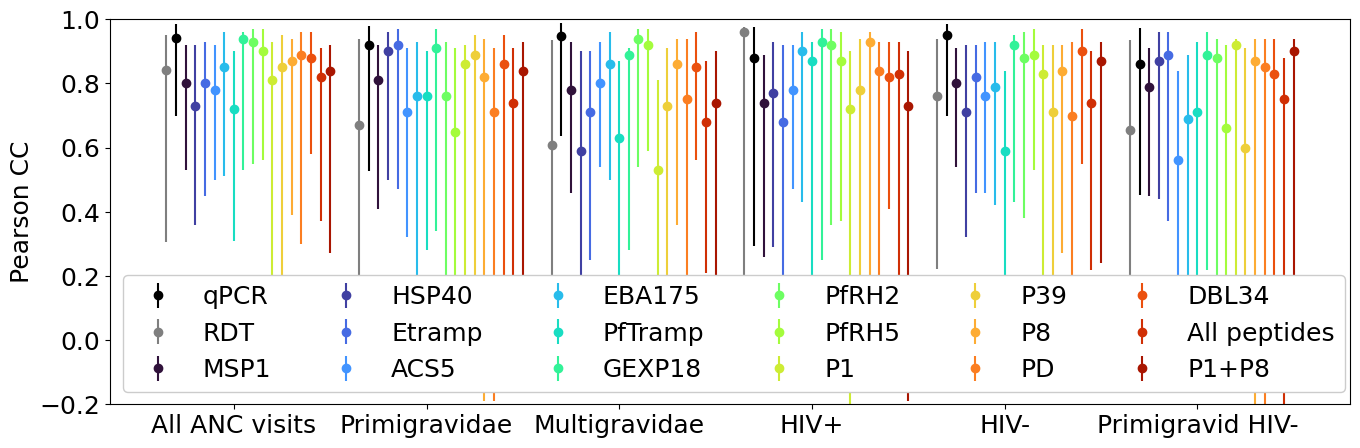

In [14]:
plt.figure(figsize = [16,5])
colors_a = [cm.turbo(i/len(antigens)) for i in range(len(antigens))]
colors_p = ['k', 'tab:grey']
labels_p = ['qPCR', 'RDT']

for i, t in enumerate(parasitology_results):
    x = np.arange(len(t)) -.05 - .05*i
    y = t['PCC']
    yerr = np.array([list(i) for i in t['PCC 95CI']]).T 
    yerr[0] = y - yerr[0]
    yerr[1] = yerr[1] - y
    plt.errorbar(x, y, yerr, marker = 'o', label = labels_p[i], color = colors_p[i], linestyle = '')
    
for i, ant in enumerate(antigens):
    x = np.arange(len(results_serology[ant])) + .05*i
    y = results_serology[ant]['PCC']
    yerr = np.array([list(i) for i in results_serology[ant]['PCC 95CI']]).T 
    yerr[0] = y - yerr[0]
    yerr[1] = yerr[1] - y
    plt.errorbar(x, y, yerr, marker = 'o', label = ant, color = colors_a[i], linestyle = '')
plt.xticks(ticks = x-.5, labels = list(results_serology[ant].index), fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.legend(ncol = 6, fontsize = fontsize, framealpha = 1)
plt.ylabel('Pearson CC', fontsize = fontsize)
plt.ylim(-.2,1)
plt.show()

In [15]:
results_serology[ant]

,Slope,Slope 95CI,Origin,Origin 95CI,PCC,PCC 95CI
All ANC visits,0.40,"[0.1, 0.88]",0.11,"[0.08, 0.15]",0.84,"[0.27, 0.92]"
Primigravidae,0.45,"[-0.01, 1.2]",0.10,"[0.05, 0.15]",0.84,"[-0.02, 0.93]"
Multigravidae,0.37,"[0.06, 0.87]",0.12,"[0.08, 0.16]",0.74,"[0.12, 0.9]"
HIV+,0.33,"[-0.1, 1.01]",0.13,"[0.07, 0.18]",0.73,"[-0.19, 0.9]"
HIV-,0.42,"[0.11, 0.96]",0.10,"[0.07, 0.14]",0.87,"[0.24, 0.93]"
Primigravid HIV-,0.48,"[-0.07, 1.18]",0.10,"[0.04, 0.15]",0.90,"[-0.12, 0.94]"
